In [ ]:
#21050111057 Mehmet Ali Yılmaz
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def get_transform(aug_type):
    """
    Returns an Albumentations Compose object for the given augmentation type.
    """
    if aug_type == 'none':
        # No augmentation, just resize and normalize
        return A.Compose([
            A.Resize(224, 224),
            A.Normalize(),
            ToTensorV2()
        ])
    elif aug_type == 'aug1':
        # Simple augmentations: horizontal flip and brightness/contrast
        return A.Compose([
            A.Resize(224, 224),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(),
            ToTensorV2()
        ])
    elif aug_type == 'aug2':
        # More complex augmentations: shift/scale/rotate and color jitter
        return A.Compose([
            A.Resize(224, 224),
            A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.7),
            A.ColorJitter(p=0.5),
            A.Normalize(),
            ToTensorV2()
        ])

class SimpleImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Read image and convert to RGB
        img = cv2.imread(self.image_paths[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Apply augmentations
        img = self.transform(image=img)['image']
        label = self.labels[idx]
        return img, label

def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():   
        for imgs, labels in loader:     
            outputs = model(imgs)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

In [3]:
# Prepare UCMerced Land-use Dataset
uc_dir = 'UCMerced_LandUse/Images'
uc_classes = sorted(os.listdir(uc_dir))

# Gather all image file paths and their class labels
uc_image_paths = []
uc_labels = []
for idx, cls in enumerate(uc_classes):
    cls_dir = os.path.join(uc_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.endswith('.tif'):
            uc_image_paths.append(os.path.join(cls_dir, fname))
            uc_labels.append(idx)

# Split into train (n > 2100), val (500), test (500)
uc_train_paths, uc_temp_paths, uc_train_labels, uc_temp_labels = train_test_split(
    uc_image_paths, uc_labels, test_size=1000, stratify=uc_labels, random_state=42)
uc_val_paths, uc_test_paths, uc_val_labels, uc_test_labels = train_test_split(
    uc_temp_paths, uc_temp_labels, test_size=0.5, stratify=uc_temp_labels, random_state=42)

# Training set sizes to use for experiments
uc_train_sizes = [20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000]

In [4]:
# Prepare Intel Image Classification Dataset
intel_train_dir = 'intel-image-classification/seg_train/seg_train'
intel_test_dir = 'intel-image-classification/seg_test/seg_test'
intel_classes = sorted(os.listdir(intel_train_dir))

# Gather all image file paths and their class labels for training
intel_image_paths = []
intel_labels = []
for idx, cls in enumerate(intel_classes):
    cls_dir = os.path.join(intel_train_dir, cls)
    for fname in os.listdir(cls_dir):
        if fname.endswith('.jpg'):
            intel_image_paths.append(os.path.join(cls_dir, fname))
            intel_labels.append(idx)

# Split into train (n > 14000), val (3000), test (3000)
intel_train_paths, intel_val_paths, intel_train_labels, intel_val_labels = train_test_split(
    intel_image_paths, intel_labels, test_size=3000, stratify=intel_labels, random_state=42)

# Prepare test set (already separated in dataset)
intel_test_paths = []
intel_test_labels = []
for idx, cls in enumerate(intel_classes):
    cls_dir = os.path.join(intel_test_dir, cls)
    if not os.path.exists(cls_dir):
        continue
    for fname in os.listdir(cls_dir):
        if fname.endswith('.jpg'):
            intel_test_paths.append(os.path.join(cls_dir, fname))
            intel_test_labels.append(idx)

# Training set sizes to use for experiments
intel_train_sizes = [20, 30, 40, 50, 60, 70, 80, 90, 100, 500, 1000]

In [ ]:
def run_experiment(model_name, dataset_name, train_paths, train_labels, val_paths, val_labels, test_paths, test_labels, all_classes, train_sizes):
    """
    Runs the experiment for a given model and dataset.
    For each augmentation and training set size, trains only the classifier (feature extractor frozen).
    Returns a dictionary of results.
    """
    results = {'none': {'train': [], 'val': [], 'test': []},
               'aug1': {'train': [], 'val': [], 'test': []},
               'aug2': {'train': [], 'val': [], 'test': []}}
    for aug_type in ['none', 'aug1', 'aug2']:
        for n in train_sizes:
            # Stratified sampling: n images per class (or as close as possible)
            sampled_paths = []
            sampled_labels = []
            for cls_idx in range(len(all_classes)):
                cls_indices = [i for i, l in enumerate(train_labels) if l == cls_idx]
                n_per_class = max(1, n // len(all_classes))
                # If not enough images, sample with replacement
                if len(cls_indices) < n_per_class:
                    chosen = random.choices(cls_indices, k=n_per_class)
                else:
                    chosen = random.sample(cls_indices, n_per_class)
                for i in chosen:
                    sampled_paths.append(train_paths[i])
                    sampled_labels.append(train_labels[i])

            # Create datasets and loaders
            train_dataset = SimpleImageDataset(sampled_paths, sampled_labels, get_transform(aug_type))
            val_dataset = SimpleImageDataset(val_paths, val_labels, get_transform('none'))
            test_dataset = SimpleImageDataset(test_paths, test_labels, get_transform('none'))

            train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

            # Load model and adapt classifier for number of classes
            if model_name == 'densenet201':
                model = models.densenet201(pretrained=True)
                model.classifier = nn.Linear(model.classifier.in_features, len(all_classes))
                # Freeze all layers except classifier
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.classifier.parameters():
                    param.requires_grad = True
            elif model_name == 'resnet50':
                model = models.resnet50(pretrained=True)
                model.fc = nn.Linear(model.fc.in_features, len(all_classes))
                # Freeze all layers except classifier
                for param in model.parameters():
                    param.requires_grad = False
                for param in model.fc.parameters():
                    param.requires_grad = True
            model = model.float()
            model.train()

            # Loss and optimizer (only classifier parameters will be updated)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

            # Train for 3 epochs (for speed)
            for epoch in range(3):
                for imgs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(imgs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

            # Evaluate on train, val, and test sets
            train_acc = evaluate(model, train_loader)
            val_acc = evaluate(model, val_loader)
            test_acc = evaluate(model, test_loader)

            # Store results
            results[aug_type]['train'].append(train_acc)
            results[aug_type]['val'].append(val_acc)
            results[aug_type]['test'].append(test_acc)
            print(f'{model_name} on {dataset_name} | Aug: {aug_type}, n={n}, Train: {train_acc:.3f}, Val: {val_acc:.3f}, Test: {test_acc:.3f}')
    return results

In [6]:
# Run all four required experiments and store results

# 1. DenseNet201 on UCMerced
results_densenet_uc = run_experiment(
    'densenet201', 'UCMerced',
    uc_train_paths, uc_train_labels,
    uc_val_paths, uc_val_labels,
    uc_test_paths, uc_test_labels,
    uc_classes, uc_train_sizes
)

# 2. ResNet50 on UCMerced
results_resnet_uc = run_experiment(
    'resnet50', 'UCMerced',
    uc_train_paths, uc_train_labels,
    uc_val_paths, uc_val_labels,
    uc_test_paths, uc_test_labels,
    uc_classes, uc_train_sizes
)

# 3. DenseNet201 on Intel
results_densenet_intel = run_experiment(
    'densenet201', 'Intel',
    intel_train_paths, intel_train_labels,
    intel_val_paths, intel_val_labels,
    intel_test_paths, intel_test_labels,
    intel_classes, intel_train_sizes
)

# 4. ResNet50 on Intel
results_resnet_intel = run_experiment(
    'resnet50', 'Intel',
    intel_train_paths, intel_train_labels,
    intel_val_paths, intel_val_labels,
    intel_test_paths, intel_test_labels,
    intel_classes, intel_train_sizes
)

C:\Users\Mehmet Ali Yilmaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Mehmet Ali Yilmaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


densenet201 on UCMerced | Aug: none, n=20, Train: 0.381, Val: 0.120, Test: 0.102
densenet201 on UCMerced | Aug: none, n=30, Train: 0.286, Val: 0.070, Test: 0.064
densenet201 on UCMerced | Aug: none, n=40, Train: 0.810, Val: 0.214, Test: 0.184
densenet201 on UCMerced | Aug: none, n=50, Train: 0.667, Val: 0.278, Test: 0.290
densenet201 on UCMerced | Aug: none, n=60, Train: 0.905, Val: 0.266, Test: 0.296
densenet201 on UCMerced | Aug: none, n=70, Train: 0.794, Val: 0.352, Test: 0.370
densenet201 on UCMerced | Aug: none, n=80, Train: 0.905, Val: 0.376, Test: 0.372
densenet201 on UCMerced | Aug: none, n=90, Train: 0.786, Val: 0.358, Test: 0.344
densenet201 on UCMerced | Aug: none, n=100, Train: 0.940, Val: 0.486, Test: 0.478
densenet201 on UCMerced | Aug: none, n=500, Train: 0.944, Val: 0.816, Test: 0.836
densenet201 on UCMerced | Aug: none, n=1000, Train: 0.959, Val: 0.898, Test: 0.902
densenet201 on UCMerced | Aug: aug1, n=20, Train: 0.619, Val: 0.148, Test: 0.122
densenet201 on UCMerced 

C:\Users\Mehmet Ali Yilmaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


densenet201 on UCMerced | Aug: aug2, n=20, Train: 0.238, Val: 0.080, Test: 0.116
densenet201 on UCMerced | Aug: aug2, n=30, Train: 0.238, Val: 0.124, Test: 0.134
densenet201 on UCMerced | Aug: aug2, n=40, Train: 0.238, Val: 0.096, Test: 0.142
densenet201 on UCMerced | Aug: aug2, n=50, Train: 0.643, Val: 0.272, Test: 0.294
densenet201 on UCMerced | Aug: aug2, n=60, Train: 0.571, Val: 0.266, Test: 0.242
densenet201 on UCMerced | Aug: aug2, n=70, Train: 0.683, Val: 0.428, Test: 0.434
densenet201 on UCMerced | Aug: aug2, n=80, Train: 0.667, Val: 0.324, Test: 0.314
densenet201 on UCMerced | Aug: aug2, n=90, Train: 0.595, Val: 0.458, Test: 0.464
densenet201 on UCMerced | Aug: aug2, n=100, Train: 0.714, Val: 0.450, Test: 0.462
densenet201 on UCMerced | Aug: aug2, n=500, Train: 0.826, Val: 0.790, Test: 0.772
densenet201 on UCMerced | Aug: aug2, n=1000, Train: 0.903, Val: 0.890, Test: 0.902


C:\Users\Mehmet Ali Yilmaz\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\Mehmet Ali Yilmaz/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:52<00:00, 1.94MB/s]


resnet50 on UCMerced | Aug: none, n=20, Train: 0.810, Val: 0.194, Test: 0.202
resnet50 on UCMerced | Aug: none, n=30, Train: 0.381, Val: 0.068, Test: 0.084
resnet50 on UCMerced | Aug: none, n=40, Train: 0.762, Val: 0.228, Test: 0.212
resnet50 on UCMerced | Aug: none, n=50, Train: 0.738, Val: 0.284, Test: 0.292
resnet50 on UCMerced | Aug: none, n=60, Train: 0.857, Val: 0.284, Test: 0.264
resnet50 on UCMerced | Aug: none, n=70, Train: 0.857, Val: 0.424, Test: 0.426
resnet50 on UCMerced | Aug: none, n=80, Train: 0.857, Val: 0.484, Test: 0.480
resnet50 on UCMerced | Aug: none, n=90, Train: 0.821, Val: 0.448, Test: 0.406
resnet50 on UCMerced | Aug: none, n=100, Train: 0.857, Val: 0.478, Test: 0.482
resnet50 on UCMerced | Aug: none, n=500, Train: 0.845, Val: 0.748, Test: 0.748
resnet50 on UCMerced | Aug: none, n=1000, Train: 0.930, Val: 0.852, Test: 0.888
resnet50 on UCMerced | Aug: aug1, n=20, Train: 0.476, Val: 0.094, Test: 0.102
resnet50 on UCMerced | Aug: aug1, n=30, Train: 0.714, Val: 0

In [7]:
def plot_results(results, train_sizes, title):
    """
    Plots train, validation, and test accuracy for each augmentation type.
    """
    plt.figure(figsize=(10,6))
    for aug_type, color, label in zip(['none', 'aug1', 'aug2'], ['b', 'g', 'r'], ['Baseline', 'Aug1', 'Aug2']):
        plt.plot(train_sizes, results[aug_type]['train'], color+'--', label=f'{label} Train')
        plt.plot(train_sizes, results[aug_type]['val'], color+'-.', label=f'{label} Val')
        plt.plot(train_sizes, results[aug_type]['test'], color+'-', label=f'{label} Test')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

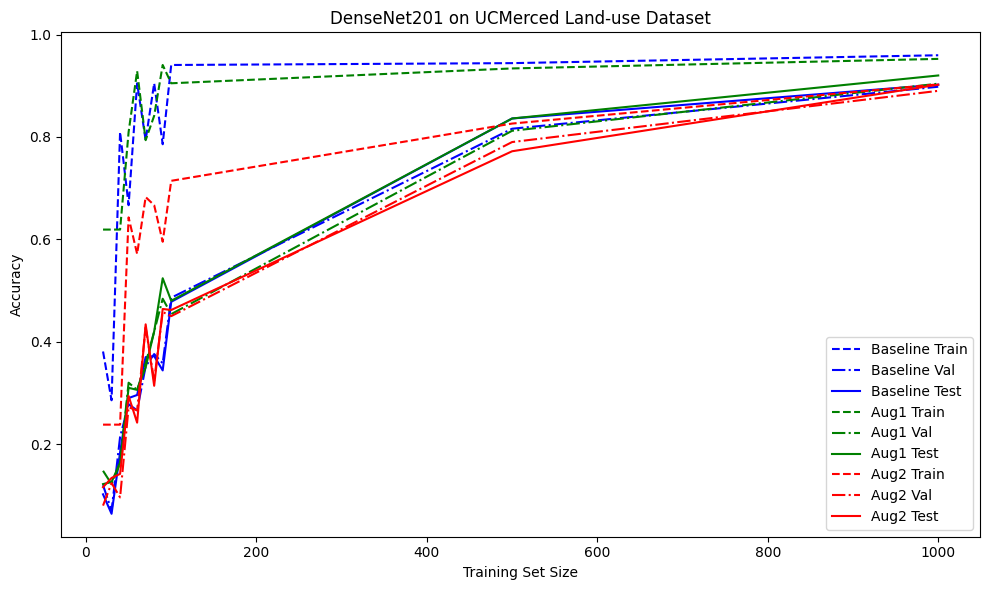

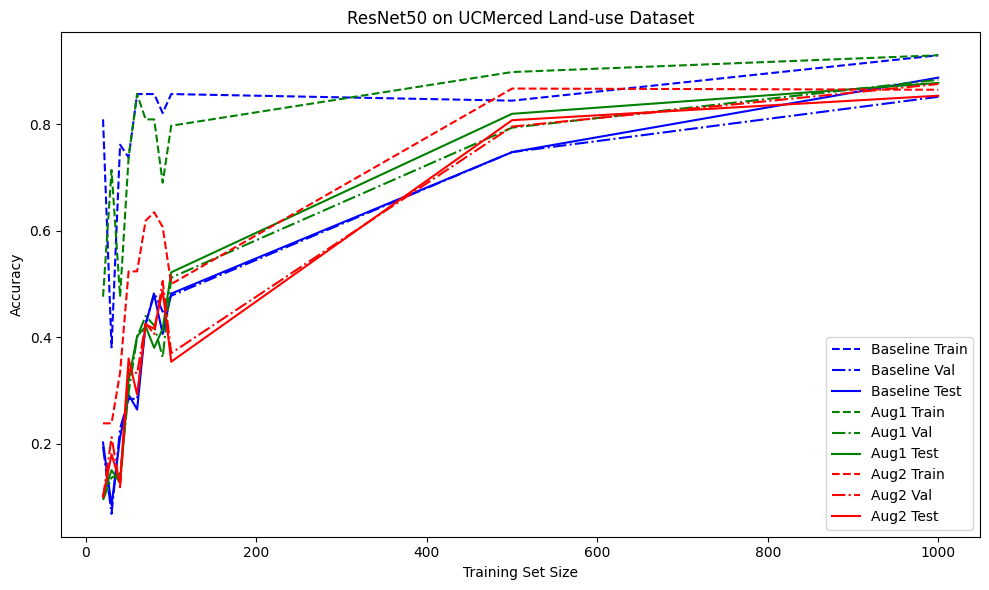

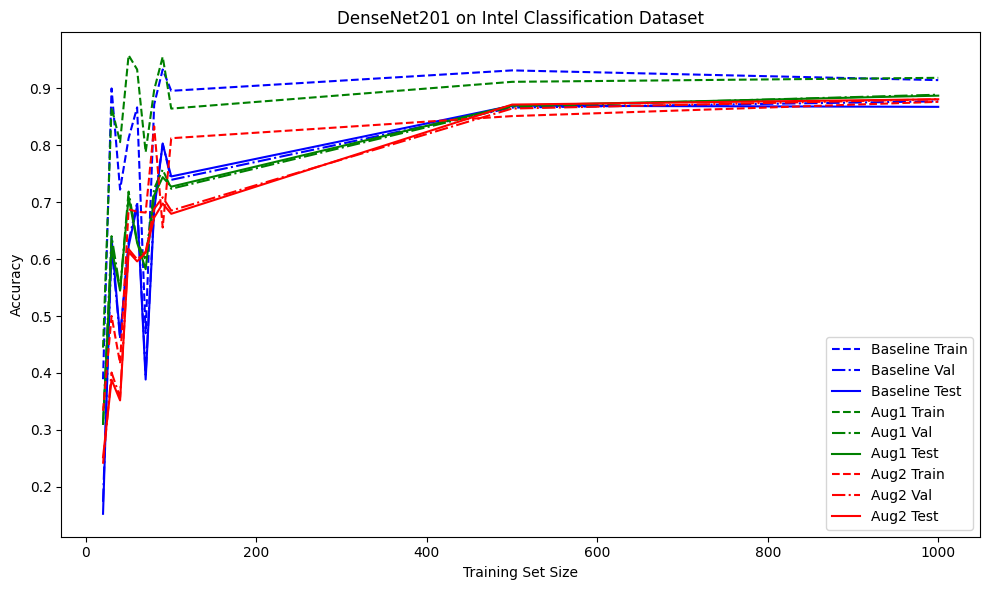

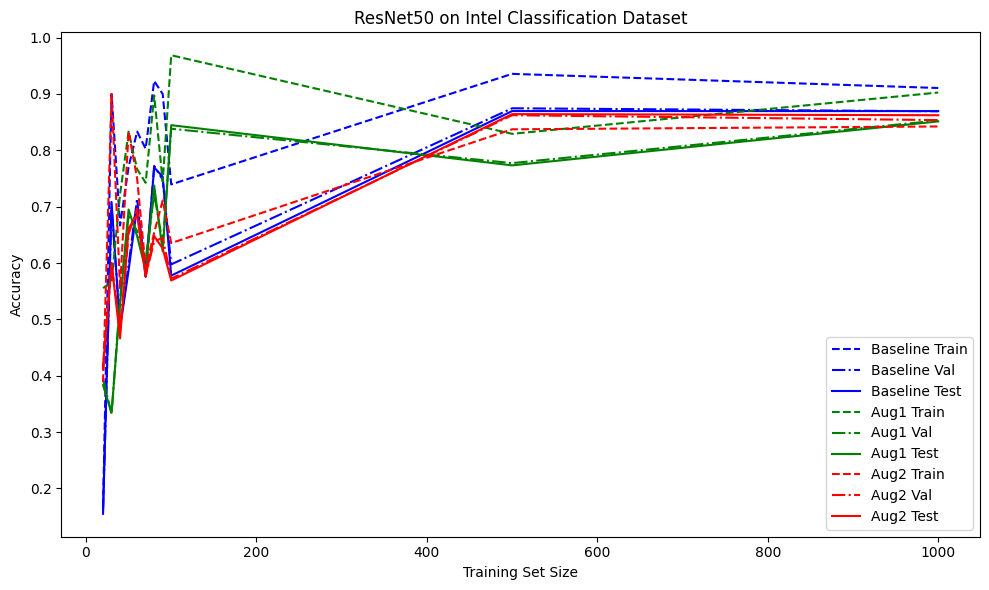

In [8]:
# Plot all four experiment results

plot_results(results_densenet_uc, uc_train_sizes, 'DenseNet201 on UCMerced Land-use Dataset')
plot_results(results_resnet_uc, uc_train_sizes, 'ResNet50 on UCMerced Land-use Dataset')
plot_results(results_densenet_intel, intel_train_sizes, 'DenseNet201 on Intel Classification Dataset')
plot_results(results_resnet_intel, intel_train_sizes, 'ResNet50 on Intel Classification Dataset')